# Semantic segmentation using Pytorch FCN-ResNet50

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'
device = torch.device('cuda')

## Data import & visualization

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms as T
from pathlib import Path

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

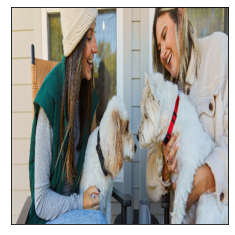

In [ ]:
image = read_image(str(Path('drive/MyDrive/Computer_vision_data') / 'dog3.png'))
image_list = [T.Resize(size=(500,500))(image)]
grid = make_grid(image_list)
show(grid)

## Model loading

In [ ]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
weights = FCN_ResNet50_Weights.DEFAULT
model = fcn_resnet50(weights=weights, progress=False).to(device)
model = model.eval()

In [ ]:
print(len(weights.meta["categories"])) # 21 classes

## Input preprocessing

In [ ]:
transforms = weights.transforms(resize_size=None)
batch = torch.stack([transforms(d) for d in image_list]).to(device)

## Inference

In [ ]:
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 500, 500]) -5.428247928619385 14.000256538391113


The output of the segmentation model is a tensor of shape (batch_size, num_classes, H, W). Each value is a non-normalized score, and we can normalize them into [0, 1] by using a softmax

After the softmax, we can interpret each value as a probability indicating how likely a given pixel is to belong to a given class.

## Output processing

In [ ]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

In [ ]:
masks = torch.nn.functional.softmax(output, dim=1) # [batchsize,class_number,H,W]

In [ ]:
print(output.shape)
print(masks.shape)

torch.Size([1, 21, 500, 500])
torch.Size([1, 21, 500, 500])


## Output visualization

### Only masks

In [ ]:
dog_and_person_masks = [
    masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(image_list))
    for cls in ('dog', 'person')
]

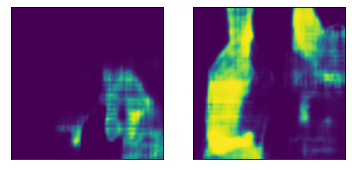

In [ ]:
show(dog_and_person_masks)

### Generated masks on top of the original images

In [ ]:
from torchvision.utils import draw_segmentation_masks
def get_boolean_masks(masks):
  num_classes = masks.shape[1] # 21
  image_boolean_masks = list()
  for index in range(len(masks)):
    image_masks = masks[index].to(device) # [21,H,W]
    image_boolean_masks.append(image_masks.argmax(0) == torch.arange(num_classes).to(device)[:, None, None])
  return image_boolean_masks

In [ ]:
boolean_masks = get_boolean_masks(masks)
show(
    [
        draw_segmentation_masks(image_list[0], masks=img_masks, alpha=.6)
        for img,img_masks in zip(image_list,boolean_masks)
    ]
)